## New York Yankees: A Sentiment Analysis of MLB Performance

In [96]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install pandas
!pip install matplotlib
!pip install lxml
!pip install nltk
!pip install wordcloud

In [97]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import lxml

import os
import re
import numpy as np
import string
import glob
import nltk
from wordcloud import WordCloud
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation

sw = stopwords.words("english")

The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

In [98]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)
    return df

# URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

In [99]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/new-york-yankees?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_new_york_yankees_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,Josh Donaldson Undecided About Playing Beyond ...,Darragh McDonald,"June 19, 2023",Yankees third baseman Josh Donaldson hasn’t ye...
1,Harrison Bader Expected To Be Activated On Jun...,Mark Polishuk,"June 18, 2023",Harrison Bader is slated to be activated from ...
2,Latest On Aaron Judge,Mark Polishuk,"June 17, 2023","Aaron Judge hasn’t played since June 3, when t..."
3,The Yankees Are Showing The Importance Of Mino...,Darragh McDonald,"June 15, 2023","Every offseason, there are huge moves that gra..."
4,"Yankees Notes: Payroll, Volpe, Bader",Anthony Franco,"June 14, 2023",The Yankees sit in third place in the loaded A...


In [100]:
# Change the Data column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [101]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [102]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [103]:
len(df)

1030

## Cleaning the Data

In [104]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [105]:
df['Content'].apply

<bound method Series.apply of 0       Yankees third baseman Josh Donaldson hasn’t ye...
1       Harrison Bader is slated to be activated from ...
2       Aaron Judge hasn’t played since June 3, when t...
3       Every offseason, there are huge moves that gra...
4       The Yankees sit in third place in the loaded A...
                              ...                        
1025                                                     
1026                                                     
1027                                                     
1028                                                     
1029                                                     
Name: Content, Length: 1030, dtype: object>

In [106]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
df['impurity'] = df['Content'].apply(impurity, min_len=10)

# get the top 3 records
df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
76,Could the Marlins match up with the Yankees on a trade involving Oswald Peraza? And which of Mia...,0.012195
146,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
333,We’ll use this post to round up some of the more notable recent draft signings:\n\nThe Phillies ...,0.002883


The steps above displays the highest impurity levels for the Athletics' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

## Character Normalization & Tokenization

In [107]:
# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
df["Contents_Normalized"] = df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,Yankees third baseman Josh Donaldson hasn’t yet decided if he’ll continue his playing career bey...,"[yanke, third, baseman, josh, donaldson, yet, decid, continu, play, career, beyond, current, cam..."
1,"Harrison Bader is slated to be activated from the 10-day injured list on Tuesday, Yankees manage...","[harrison, bader, slate, activ, day, injur, list, tuesday, yanke, manag, aaron, boon, told, athl..."
2,"Aaron Judge hasn’t played since June 3, when the Yankees superstar made a highlight-reel catch t...","[aaron, judg, play, sinc, june, yanke, superstar, made, highlightreel, catch, sent, crash, dodge..."
3,"Every offseason, there are huge moves that grab headlines and have the ability to transform fran...","[everi, offseason, huge, move, grab, headlin, abil, transform, franchis, top, free, agent, get, ..."
4,The Yankees sit in third place in the loaded AL East despite a 39-30 record. They’re unquestiona...,"[yanke, sit, third, place, load, al, east, despit, record, unquestion, approach, deadlin, season..."


In [108]:
df['length'] = df['Contents_Normalized'].str.len()
df.head()

,Title,Author,Date,Content,impurity,Contents_Normalized,length
0,Josh Donaldson Undecided About Playing Beyond 2023,Darragh McDonald,2023-06-19,Yankees third baseman Josh Donaldson hasn’t yet decided if he’ll continue his playing career bey...,0.000000,"[yanke, third, baseman, josh, donaldson, yet, decid, continu, play, career, beyond, current, cam...",364
1,Harrison Bader Expected To Be Activated On June 20,Mark Polishuk,2023-06-18,"Harrison Bader is slated to be activated from the 10-day injured list on Tuesday, Yankees manage...",0.000000,"[harrison, bader, slate, activ, day, injur, list, tuesday, yanke, manag, aaron, boon, told, athl...",70
2,Latest On Aaron Judge,Mark Polishuk,2023-06-17,"Aaron Judge hasn’t played since June 3, when the Yankees superstar made a highlight-reel catch t...",0.000602,"[aaron, judg, play, sinc, june, yanke, superstar, made, highlightreel, catch, sent, crash, dodge...",328
3,The Yankees Are Showing The Importance Of Minor League Deals,Darragh McDonald,2023-06-15,"Every offseason, there are huge moves that grab headlines and have the ability to transform fran...",0.000000,"[everi, offseason, huge, move, grab, headlin, abil, transform, franchis, top, free, agent, get, ...",499
4,"Yankees Notes: Payroll, Volpe, Bader",Anthony Franco,2023-06-14,The Yankees sit in third place in the loaded AL East despite a 39-30 record. They’re unquestiona...,0.000000,"[yanke, sit, third, place, load, al, east, despit, record, unquestion, approach, deadlin, season...",395


<Axes: >

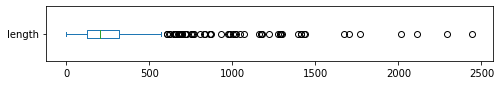

In [109]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

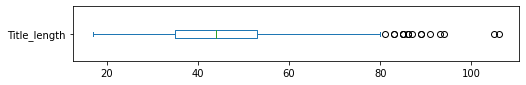

In [110]:
df['Title_length'] = df['Title'].str.len()
df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

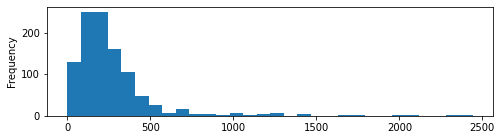

In [111]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='Date'>

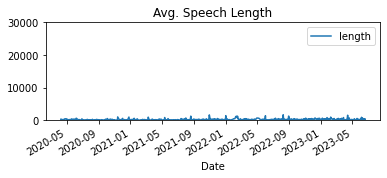

In [112]:
df.groupby('Date').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))


Import data on the New York Yankees from baseball-reference.com.

https://www.baseball-reference.com/teams/NYY/attend.shtml

In [113]:
# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/NYY/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/yankees_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/yankees_statistics.csv


In [114]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

yankees_df = pd.DataFrame(pd.read_csv(path + 'yankees_statistics.csv'))
yankees_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,New York Yankees,AL East,39,33,3,NaN,1492377.0,39273.0,1st of 15,"$270,202,722",99,100,Yankee Stadium III
1,2022,New York Yankees,AL East,99,63,1,Lost ALCS (4-0),3136207.0,38719.0,1st of 15,"$238,950,714",99,100,Yankee Stadium III
2,2021,New York Yankees,AL East,92,70,2,Lost ALWC (1-0),1959854.0,24196.0,3rd of 15,"$209,799,047",99,100,Yankee Stadium III
3,2020,New York Yankees,AL East,33,27,2,Lost ALDS (3-2),NaN,NaN,10th of 15,"$218,635,714",96,97,Yankee Stadium III
4,2019,New York Yankees,AL East,103,59,1,Lost ALCS (4-2),3304404.0,40795.0,1st of 15,"$228,442,421",96,98,Yankee Stadium III


In [115]:
yankees_df= yankees_df[yankees_df['Year'] > 2004]
yankees_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,New York Yankees,AL East,39,33,3,NaN,1492377.0,39273.0,1st of 15,"$270,202,722",99,100,Yankee Stadium III
1,2022,New York Yankees,AL East,99,63,1,Lost ALCS (4-0),3136207.0,38719.0,1st of 15,"$238,950,714",99,100,Yankee Stadium III
2,2021,New York Yankees,AL East,92,70,2,Lost ALWC (1-0),1959854.0,24196.0,3rd of 15,"$209,799,047",99,100,Yankee Stadium III
3,2020,New York Yankees,AL East,33,27,2,Lost ALDS (3-2),NaN,NaN,10th of 15,"$218,635,714",96,97,Yankee Stadium III
4,2019,New York Yankees,AL East,103,59,1,Lost ALCS (4-2),3304404.0,40795.0,1st of 15,"$228,442,421",96,98,Yankee Stadium III
5,2018,New York Yankees,AL East,100,62,2,Lost ALDS (3-1),3482855.0,42998.0,1st of 15,"$160,643,032",98,100,Yankee Stadium III
6,2017,New York Yankees,AL East,91,71,2,Lost ALCS (4-3),3154938.0,38950.0,2nd of 15,"$182,424,700",103,104,Yankee Stadium III
7,2016,New York Yankees,AL East,84,78,4,NaN,3063405.0,37820.0,2nd of 15,"$193,229,350",102,103,Yankee Stadium III
8,2015,New York Yankees,AL East,87,75,2,Lost ALWC (1-0),3193795.0,39430.0,1st of 15,"$214,051,957",101,101,Yankee Stadium III
9,2014,New York Yankees,AL East,84,78,2,NaN,3401624.0,41995.0,1st of 15,"$258,118,959",100,100,Yankee Stadium III


In [116]:
#remove dollar, comma signs from the following columns
yankees_df['Est. Payroll'] = yankees_df['Est. Payroll'].replace({'\$':''}, regex = True)
yankees_df['Est. Payroll'] = yankees_df['Est. Payroll'].replace({'\,':''}, regex = True)
yankees_df['Attendance'] = yankees_df['Attendance'].replace({'\,':''}, regex = True)
yankees_df['Attend/G'] = yankees_df['Attend/G'].replace({'\,':''}, regex = True)
yankees_df['Stadium'] = yankees_df['Stadium'].replace({'\,':''}, regex = True)
yankees_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,New York Yankees,AL East,39,33,3,NaN,1492377.0,39273.0,1st of 15,270202722,99,100,Yankee Stadium III
1,2022,New York Yankees,AL East,99,63,1,Lost ALCS (4-0),3136207.0,38719.0,1st of 15,238950714,99,100,Yankee Stadium III
2,2021,New York Yankees,AL East,92,70,2,Lost ALWC (1-0),1959854.0,24196.0,3rd of 15,209799047,99,100,Yankee Stadium III
3,2020,New York Yankees,AL East,33,27,2,Lost ALDS (3-2),NaN,NaN,10th of 15,218635714,96,97,Yankee Stadium III
4,2019,New York Yankees,AL East,103,59,1,Lost ALCS (4-2),3304404.0,40795.0,1st of 15,228442421,96,98,Yankee Stadium III


In [117]:
yankees_df['Est. Payroll'] = yankees_df['Est. Payroll'].astype(float)
yankees_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

In [118]:
yankees_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000
mean,2014.000000,87.473684,64.421053,1.894737,3.392156e+06,43036.666667,2.141392e+08,100.263158,101.421053
std,5.627314,19.074032,13.487920,0.875261,7.320794e+05,6950.097731,2.593502e+07,2.600045,2.673238
min,2005.000000,33.000000,27.000000,1.000000,1.492377e+06,24196.000000,1.606430e+08,96.000000,97.000000
25%,2009.500000,86.000000,62.500000,1.000000,3.164652e+06,39312.250000,2.021265e+08,99.000000,100.000000
50%,2014.000000,94.000000,67.000000,2.000000,3.442240e+06,42496.500000,2.103300e+08,100.000000,101.000000
75%,2018.500000,97.000000,72.000000,2.000000,3.754195e+06,46347.750000,2.235391e+08,102.500000,103.500000
max,2023.000000,103.000000,78.000000,4.000000,4.298655e+06,53070.000000,2.702027e+08,105.000000,106.000000


Text(0.5, 1.0, 'Attendance of New York Yankees over the years')

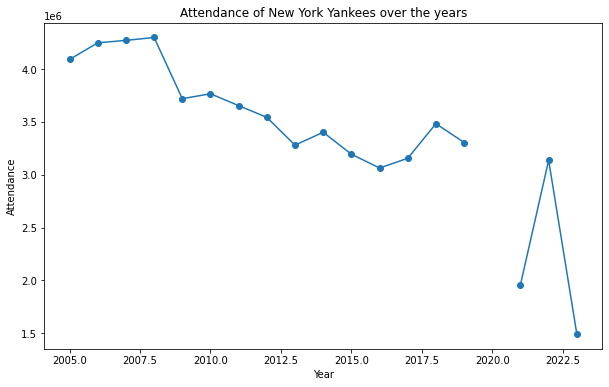

In [119]:
#plot data
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(yankees_df['Year'], yankees_df['Attendance'], marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of New York Yankees over the years')

Text(0.5, 1.0, 'Wins of New York Yankees over the years')

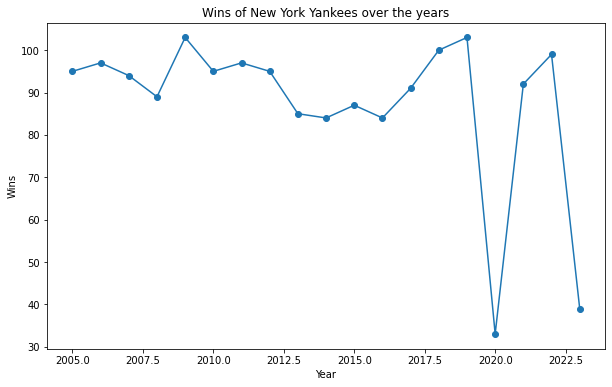

In [120]:
# Plotting Wins over the years
plt.figure(figsize=(10, 6))
plt.plot(yankees_df['Year'], yankees_df['W'], marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins of New York Yankees over the years')

Text(0.5, 1.0, 'Payroll of New York Yankees over the years')

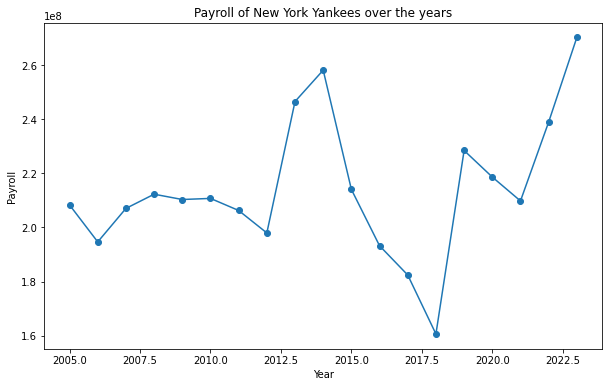

In [121]:
# Plotting Payroll over the years
plt.figure(figsize=(10, 6))
plt.plot(yankees_df['Year'], yankees_df['Est. Payroll'], marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of New York Yankees over the years')

                  Year         W         L    Finish  Attendance  Attend/G  \
Year          1.000000 -0.445695 -0.425793  0.225589   -0.852456 -0.823493   
W            -0.445695  1.000000  0.746419 -0.443475    0.668311  0.217084   
L            -0.425793  0.746419  1.000000  0.077582    0.482187  0.018391   
Finish        0.225589 -0.443475  0.077582  1.000000   -0.334045 -0.216730   
Attendance   -0.852456  0.668311  0.482187 -0.334045    1.000000  0.837342   
Attend/G     -0.823493  0.217084  0.018391 -0.216730    0.837342  1.000000   
Est. Payroll  0.283764 -0.452365 -0.273449  0.143944   -0.421004 -0.171575   
PPF          -0.261732  0.275694  0.359131  0.067727    0.074749  0.052521   
BPF          -0.307524  0.343725  0.294097  0.001269    0.162041  0.156780   

              Est. Payroll       PPF       BPF  
Year              0.283764 -0.261732 -0.307524  
W                -0.452365  0.275694  0.343725  
L                -0.273449  0.359131  0.294097  
Finish            0.143

Text(0.5, 1.0, 'Correlation Matrix')

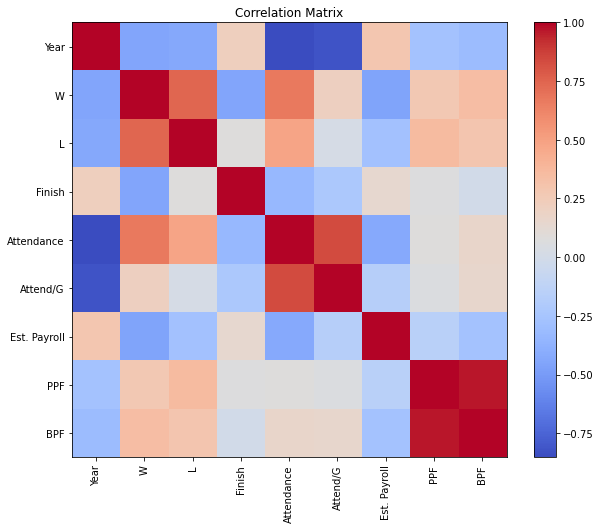

In [15]:
# Correlation matrix
correlation = yankees_df.corr()
print(correlation)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title('Correlation Matrix')

## Descriptive Stats of Data

In [122]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        c = Counter(tokens)
        top_five = c.most_common(5)
        top_five_df = pd.DataFrame(top_five, columns= ['Token', 'Count'])
        print("\nFive Most Common Tokens: \n\n", top_five_df)

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [123]:
# Clean the data
punctuation = set(punctuation)

yankees_clean_df = yankees_df.copy()
yankees_clean_df = yankees_clean_df.dropna()

stop_words = stopwords.words('english')
yankees_nostop = yankees_clean_df.apply(lambda x: [item for item in x if item not in stop_words])
yankees_clean_df = yankees_nostop

In [124]:
print("\nNew York Yankees Results:\n")
print(descriptive_stats(yankees_clean_df))


New York Yankees Results:

There are 13 tokens in the data.
There are 14 unique tokens in the data.
There are 71 characters in the data.
The lexical diversity is 1.077 in the data.

Five Most Common Tokens: 

   Token  Count
0  Year      1
1    Tm      1
2    Lg      1
3     W      1
4     L      1
[13, 14, 1.0769230769230769, 71]
